<a href="https://colab.research.google.com/github/reggy0/depth_guide/blob/main/psuedo_GT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use this to discard all changes and reset 

In [ ]:
# !kill -9 -1

Uncomment all 'deb-src' lines to allow apt to download source code for dependencies

In [ ]:
with open('/etc/apt/sources.list') as f:
  txt = f.read()
with open('/etc/apt/sources.list.backup', 'w') as f:
  f.write(txt)
with open('/etc/apt/sources.list', 'w') as f:
  f.write(txt.replace('# deb-src','deb-src'))

Update apt 

Install dependencies for Caffe with CUDA

Install g++-5: this is a way to make g++, nvcc and boost work together

In [ ]:
!apt update
!apt build-dep caffe-cpu
!apt install g++-5

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.canonical.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 

Download sources for boost

Unpack boost

In [ ]:
!wget https://dl.bintray.com/boostorg/release/1.67.0/source/boost_1_67_0.tar.bz2
!tar --bzip2 -xf boost_1_67_0.tar.bz2

--2021-06-05 15:33:02--  https://dl.bintray.com/boostorg/release/1.67.0/source/boost_1_67_0.tar.bz2
Resolving dl.bintray.com (dl.bintray.com)... 52.42.217.145, 52.43.14.61, 34.218.153.129, ...
Connecting to dl.bintray.com (dl.bintray.com)|52.42.217.145|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2021-06-05 15:33:03 ERROR 403: Forbidden.

tar (child): boost_1_67_0.tar.bz2: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


Set g++-5 and gcc-5 as default compiles: we're gonna use them to compile both boost and Caffe 

In [ ]:
!update-alternatives --remove-all gcc 
!update-alternatives --remove-all g++

!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
!update-alternatives --set cc /usr/bin/gcc

!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
!update-alternatives --set c++ /usr/bin/g++

update-alternatives: error: no alternatives for gcc
update-alternatives: error: no alternatives for g++
update-alternatives: using /usr/bin/gcc-5 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/g++-5 to provide /usr/bin/g++ (g++) in auto mode


Compile and install boost

In [ ]:
!cd boost_1_67_0 && ./bootstrap.sh --exec-prefix=/usr/local --with-libraries=system,filesystem,regex,thread,python \
--with-python-version=2.7 --with-python-root=/usr
!cd boost_1_67_0 && ./b2 install

/bin/bash: line 0: cd: boost_1_67_0: No such file or directory
/bin/bash: line 0: cd: boost_1_67_0: No such file or directory


Clone Caffe from github, checkout SSD branch

In [ ]:
!git clone https://github.com/weiliu89/caffe.git && cd caffe && git checkout ssd

Cloning into 'caffe'...
remote: Enumerating objects: 30179, done.
remote: Total 30179 (delta 0), reused 0 (delta 0), pack-reused 30179
Receiving objects: 100% (30179/30179), 48.27 MiB | 29.76 MiB/s, done.
Resolving deltas: 100% (19451/19451), done.
Branch 'ssd' set up to track remote branch 'ssd' from 'origin'.
Switched to a new branch 'ssd'


Configure makefile:

- Set path to CUDA
- Set BLAS option
- Set opencv version 3
- Add Python layer (just in case)
- Add some unrecognized paths to hdf5 and numpy

In [ ]:
with open('caffe/Makefile.config.example') as f:
  config = f.read()
  
comment = ['CUDA_DIR := /usr/local/cuda', 
           'BLAS := open']
uncomment = ['# BLAS := atlas', 
             '# OPENCV_VERSION := 3', '# WITH_PYTHON_LAYER := 1','# CPU_ONLY := 1'] #
replace = [('INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include',
            'INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include /usr/include/hdf5/serial /usr/local/lib/python2.7/dist-packages/numpy/core/include/'), 
           ('LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib',
            'LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib /usr/lib/x86_64-linux-gnu/hdf5/serial')]

for c in uncomment:
  config = config.replace(c, c[2:])
for c in comment:
  config = config.replace(c, '# '+c)
for c1,c2 in replace:
  config = config.replace(c1, c2)
  
with open('caffe/Makefile.config', 'w') as f:
  f.write(config)

Replace '-isystem' in Makefile by '-I' to prevent errors with locating stdlib: adopted from https://github.com/Martchus/tageditor/issues/22

In [ ]:
with open('caffe/Makefile') as f:
  mfile = f.read()
  
with open('caffe/Makefile.backup', 'w') as f:
  f.write(mfile)
  
with open('caffe/Makefile', 'w') as f:
  f.write(mfile.replace('-isystem','-I'))

Magic thing to avoid errors with nan-related types: adopted from 

https://stackoverflow.com/questions/47200632/caffe-installation-gcc-error-namespace-std-has-no-member-isnan

In [ ]:
with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h') as f:
  txt = f.read()
with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h', 'w') as f:
  f.write(txt.replace('/* #undef _GLIBCXX_USE_C99_MATH */',
                      '/* #undef _GLIBCXX_USE_C99_MATH */\n#define  _GLIBCXX_USE_C99_MATH  1'))

Now actually make Caffe, python interface and tests

In [ ]:
!cd caffe && make -j8 && make pycaffe && make test -j8 && make distribute

Add path with installed libs (namely boost and caffe) to configs

In [ ]:
!echo /usr/local/lib >> /etc/ld.so.conf && ldconfig
!echo /content/caffe/distribute/lib >> /etc/ld.so.conf && ldconfig

/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



We are ready to test Caffe!

In [ ]:
import sys
import os
caffe_path = !cd caffe/python && pwd
sys.path.insert(0, caffe_path[0])  
import caffe

import cv2
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
!git clone https://github.com/tnarihi/direct-intrinsics

In [ ]:
import sys
import glob

In [ ]:
#clone the github repo here
sys.path.append('/content/direct-intrinsics/model_release')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import caffe
import direct_intrinsics as di

In [ ]:
# caffe.set_mode_gpu()
modelfile = '/content/direct-intrinsics/model_release/sintel_final_train.caffemodel'

# Load net
net = caffe.Net('/content/direct-intrinsics/model_release/direct_intrinsics.prototxt', modelfile, caffe.TEST)

Load the net:

In [ ]:
# Load an image
obj_id = 263
# obj = di.mit_objects['test'][obj_id]
# print obj
img = cv2.imread('/content/drive/MyDrive/Oxford_Data/trainA/{}.png'.format(obj_id))
# mask = cv2.imread('/home/narihira/data/DI-MIT-intrinsic/data/{}/mask.png'.format(obj))
# mask[mask > 0] = 1

In [ ]:
# Predict by Direct intrinsics CNN
a, s = di.predict(net, img)

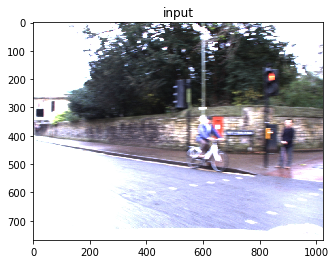

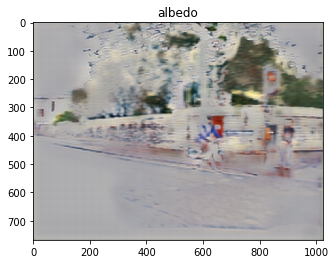

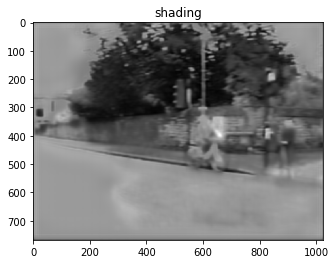

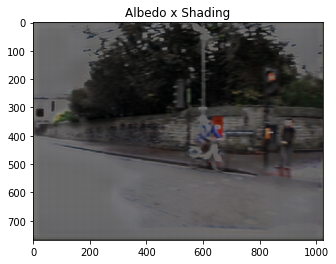

In [ ]:
# Display results
plt.figure()
plt.title('input')
plt.imshow(di.bgr2rgb(img))
plt.figure()
plt.title('albedo')
plt.imshow(a)
plt.figure()
plt.title('shading')
plt.imshow(s)
plt.figure()
plt.title('Albedo x Shading')
plt.imshow(s*a)

In [ ]:
# Load net
modelfile = '/content/direct-intrinsics/model_release/sintel_final_test.caffemodel'
net = caffe.Net('/content/direct-intrinsics/model_release/direct_intrinsics.prototxt', modelfile, caffe.TEST)

In [ ]:


# Load an image
obj_id = 0
# obj = di.mit_objects['test'][obj_id]
# print obj
img = cv2.imread('/content/drive/MyDrive/Oxford_Data/trainB/{}.png'.format(obj_id))
# mask = cv2.imread('/home/narihira/data/DI-MIT-intrinsic/data/{}/mask.png'.format(obj))
# mask[mask > 0] = 1

# Predict by Direct intrinsics CNN
a, s = di.predict(net, img)

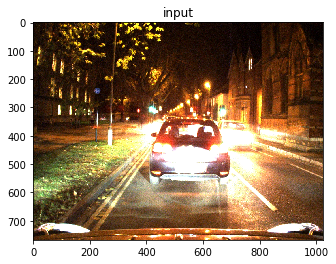

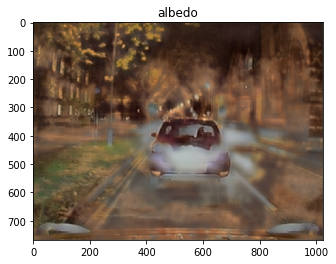

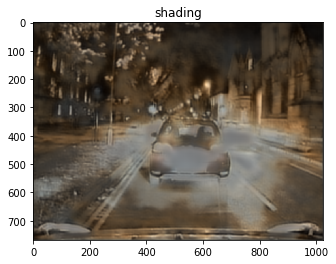

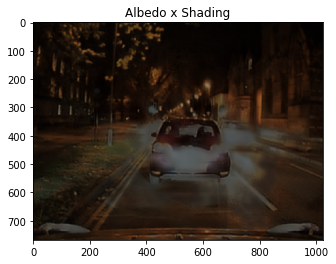

In [ ]:
# Display results
plt.figure()
plt.title('input')
plt.imshow(di.bgr2rgb(img))
plt.figure()
plt.title('albedo')
plt.imshow(a)
plt.figure()
plt.title('shading')
plt.imshow(s)
plt.figure()
plt.title('Albedo x Shading')
plt.imshow(s*a)